<h1>Experiment 5.1. - Adaptive $t_k$ (constant $\beta$) vs adaptive $t_k$ and $s_k$</h1>
<p>
    This file provides the code for recreating the experiment from Section 5.1. 
</p>
<p>
    <h3>Step 1:</h3>
    Definition of the problem setup and all necessary functions which change with the given problem.
</p>

In [1]:
# imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# settings which determine the contect of the problem
m = 200
n = 100

steps = 1000

lamb = 1

In [3]:
# in order to recreate the images from Figure 5.1 set the seed to 1
np.random.seed(1)

# creation of the problem setting
A = np.random.uniform(-1.0, 1.0, (m, n))
b = np.random.uniform(-1.0, 1.0, m)

# get some initial guesses
p_start = np.random.uniform(-1.0, 1.0, n)
q_start = np.random.uniform(-1.0, 1.0, m)

In [4]:
# objective function which is supposed to be minimized
def F(A, b, lamb, x):
    return np.linalg.norm(A @ x - b, 1) + lamb * np.linalg.norm(x, 1)

In [5]:
# proximal mapping of f
def prox_f(x, t, lamb):
    return np.sign(x) * np.maximum(np.abs(x) - t*lamb, 0.0)

# proximal maping of the convex conjugate of g
def prox_g_c(y, s, b):
    return y - s * b - np.sign(y - s * b) * np.maximum(np.abs(y - s * b) - 1.0, 0.0)

In [6]:
# matrices used in the following function
I_m = np.identity(m)
I_n = np.identity(n)

# compute resolvent of the matrix part of primal-dual DR
def matrix_resolvent(A, x, y, t, s):
    mat = np.block([[I_n, t * A.transpose()],
                    [-1.0 * s * A, I_m]])
    
    c = np.linalg.solve(mat, np.concatenate((x,y)))
    
    return c[:n], c[n:]

<p>
    <h3>Step 2:</h3>
    Definitions of the different stepsizes (stepsize methods) which should be used during the DR method later on
</p>

In [7]:
# define stepsize-methods which should be used later in the DR-algorithm
# all of them have to return values for both t and s.
# if only one stepsize t should vary, return t,t

# 'step' indicates the step in which we are in. 
# the functions will be called with step=-1 to get an initial stepsize before DR starts

# stepsize method for the stepsize t=1
def constant_1(p, q, x, y, t_before, s_before, step):
    return 1.0, 1.0

# stepsize method for t adaptive
def adaptive_t(p, q, x, y, t_before, s_before, step):
    
    # initial stepsize
    if step == -1:
        return 1.0, 1.0
    
    #stepsize for all steps >= 0
    w = np.power(2, (-1.0 * step)/100.0)
    
    frac = np.linalg.norm(np.concatenate((x,y)))/np.linalg.norm(np.concatenate((p-x,q-y)))
    frac = max(min(frac, 10e4), 10e-4)
    
    t = (1.0 + w * frac - w) * t_before
    
    return t, t

# stepsize method for both t and s adaptive
def adaptive_ts(p, q, x, y, t_before, s_before, step):
    
    # initial stepsize
    if step == -1:
        return 1.0, 1.0
    
    #stepsize for all steps >= 0
    w = np.power(2, (-1.0 * step)/100.0)
    
    frac_t = np.linalg.norm(x)/np.linalg.norm(p-x)
    frac_t = max(min(frac_t, 10e4), 10e-4)
    
    frac_s = np.linalg.norm(y)/np.linalg.norm(q-y)
    frac_s = max(min(frac_s, 10e4), 10e-4)
    
    t = (1.0 + w * frac_t - w) * t_before
    s = (1.0 + w * frac_s - w) * s_before
    
    return t, s

# list methods to be considered in here. 
# structure is as follows: name/key of method, function callback, plot-type, plot-color
methods = [
    ['constant $t=1$', constant_1, '-.', 'blue'],
    ['$t$-adaptive', adaptive_t, '--', 'red'],
    ['$(t,s)$-adaptive', adaptive_ts, '-', 'green']
]

<p>
    <h3>Step 3:</h3>
    Execution of the DR method itself for all of the previously defined methods.
</p>

In [8]:
# dictionaries in which all of the results from the DR iterations
# will be stored for each method
stepsizes_t = dict()
stepsizes_s = dict()
F_evals = dict()

# apply DR for each of the methods listed above
for method in methods:
    # store values in these lists
    stepsizes_t[method[0]] = []
    stepsizes_s[method[0]] = []
    F_evals[method[0]] = []

    # same starting point for each method
    p = p_start.copy()
    q = q_start.copy()
    
    x = np.zeros(n)
    y = np.zeros(m)
    
    # initial stepsizes
    t, s = method[1](p, q, x, y, 0, 0, -1)

    # start of DR method
    # loop through it more than necessary to get a better result for later comparison
    for step in range(3 * steps):
        x = prox_f(p, t, lamb)
        y = prox_g_c(q, s, b)
    
        u, v = matrix_resolvent(A, 2.0 * x - p, 2.0 * y - q, t, s)
        
        # computation of new stepsizes
        t, s = method[1](p, q, x, y, t, s, step)
    
        p = p + u - x
        q = q + v - y
    
        # store all values
        stepsizes_t[method[0]].append(t)
        stepsizes_s[method[0]].append(s)
        F_evals[method[0]].append(F(A, b, lamb, x))
    

<p>
    <h3>Step 4:</h3>
    Plot of the results from before.
</p>

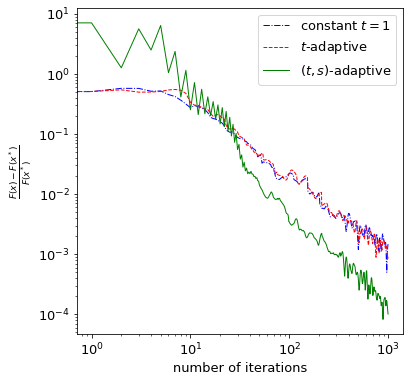

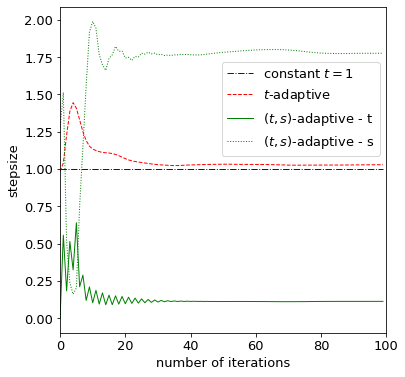

In [9]:
# modification of the decay values for plotting
def normalize_plot_values(vals, length, optimal):
    
    plot_vals = []
    
    for i in range(length):
        
        # if-condition prevents outbreaks of the graph to -inf in loglog plot
        if vals[i] != optimal:
            plot_vals.append(np.abs(vals[i] - optimal)/optimal)
        else:
            plot_vals.append(plot_vals[-1])
            
    return plot_vals

# set the text style
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

### first figure with decay of values

figure_F, ax_F = plt.subplots(1, figsize=(6, 6))

# styling the box
ax_F.set_box_aspect(1)
ax_F.set(xlabel="number of iterations", ylabel=r"$\frac{F(x) - F(x^*)}{F(x^*)}$")

# value which we assume to be optimal (after 3x of the considered iterations)
optimal = min([F_evals[method[0]][-1] for method in methods])

# plot the decay for each method with the styles defined before
for method in methods:
    ax_F.loglog(range(steps),
                normalize_plot_values(F_evals[method[0]], steps, optimal),
                label = method[0],
                linestyle = method[2],
                linewidth = 1.0,
                color = method[3]
                )

# show plot and perhabs store it as graphics
ax_F.legend()
#plt.savefig("single-vs-double-adaptive-F.pdf", bbox_inches='tight')
plt.show()

### second figure with development of eigenvalues

figure_ts, ax_ts = plt.subplots(1, figsize=(6, 6))

# styling
ax_ts.set_box_aspect(1)
ax_ts.set(xlabel="number of iterations", ylabel="stepsize")
ax_ts.set_xlim([0, 100])

# plot the development of the stepsizes in second plot
# for (t,s)-adaptive method both stepsizes have to be plotted
ax_ts.plot(range(100),
            stepsizes_t['constant $t=1$'][:100],
            label='constant $t=1$',
            linestyle='-.',
            linewidth=1.0,
            color='blue'
      )

ax_ts.plot(range(100),
            stepsizes_t['$t$-adaptive'][:100],
            label='$t$-adaptive',
            linestyle='--',
            linewidth=1.0,
            color='red'
      )

ax_ts.plot(range(100),
            stepsizes_t['$(t,s)$-adaptive'][:100],
            label='$(t,s)$-adaptive - t',
            linestyle='-',
            linewidth=1.0,
            color='green'
      )

ax_ts.plot(range(100),
            stepsizes_s['$(t,s)$-adaptive'][:100],
            label='$(t,s)$-adaptive - s',
            linestyle=':',
            linewidth=1.0,
            color='green'
      )


# show plot and perhabs store it as graphics   
ax_ts.legend(loc="upper right", bbox_to_anchor=(1,0.85))
#plt.savefig("single-vs-double-adaptive-t.pdf", bbox_inches='tight')
plt.show()